## The Problem with Deep Neural Networks
### Theoretical Expectation:
   Stacking more layers allows the network to learn   increasingly complex features, improving model performance.

### Practical Reality:
Adding more layers often causes performance to plateau or degrade due to:

 1. Vanishing Gradients: Gradients become too small as they propagate backward, making early layers learn very slowly.

* Fix: Batch Normalization and better weight initialization help stabilize training.
2. Identity Function Learning Issue: Deeper networks fail to preserve input features (identity mapping), which is essential for effective learning.

* Fix: Residual Modules explicitly add skip connections, enabling the network to retain and use input features efficiently.

## Residual Model Diagram:
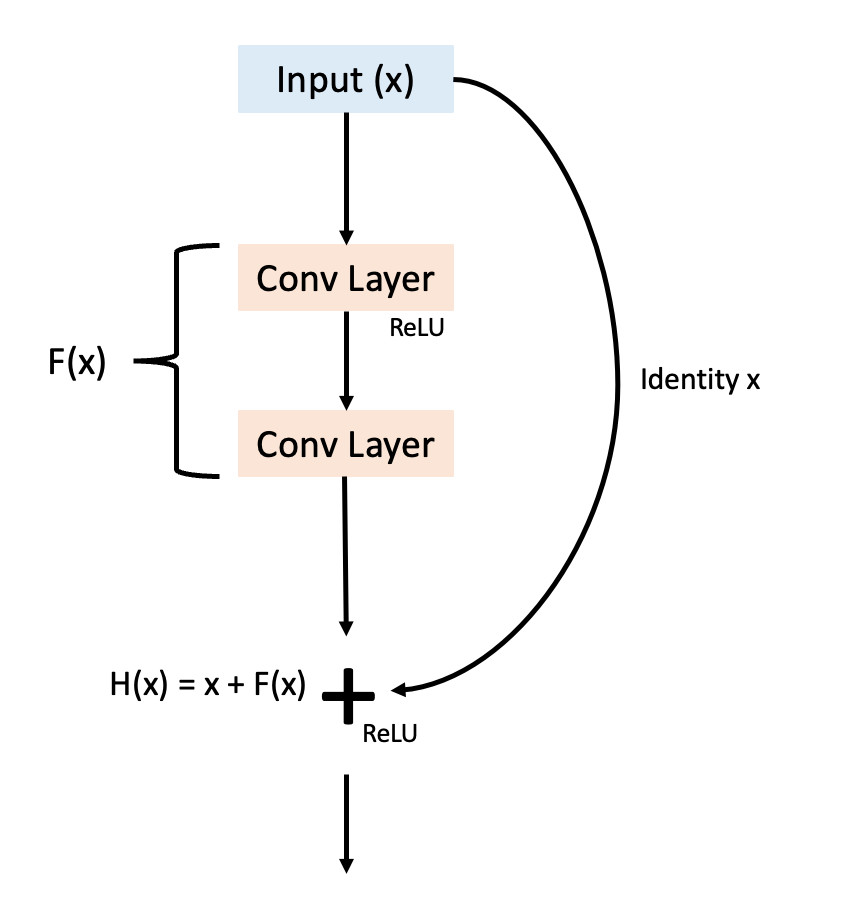
* Skip connection provides a clear path for gradients to backpropagate to early layers of the network. This makes the learning process faster by avoiding the vanishing gradient problem.
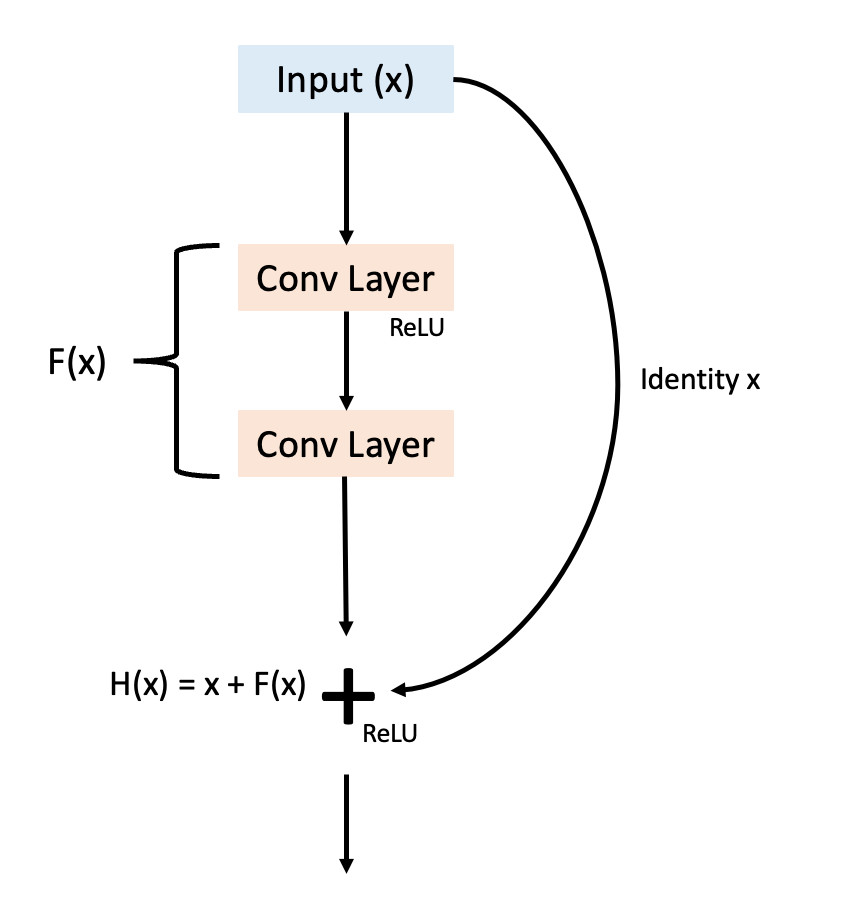

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# dataset directory
train_dir = "/kaggle/input/vgg2subset/dataset/train"
val_dir = "/kaggle/input/vgg2subset/dataset/val"
test_dir = "/kaggle/input/vgg2subset/dataset/test"


In [3]:
#  Define the transform for calculating mean and std
first_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#  Load the training dataset for normalization
train_dataset = datasets.ImageFolder(root=train_dir, transform=first_transform)

#  Calculate mean and std
def calculate_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_imgs = 0
    for images, _ in dataloader:
        batch_mean = torch.mean(images, dim=[0, 2, 3])
        batch_std = torch.std(images, dim=[0, 2, 3])
        batch_size = images.size(0)
        mean += batch_mean * batch_size
        std += batch_std * batch_size
        total_imgs += batch_size
    mean /= total_imgs
    std /= total_imgs
    return mean, std
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
mean, std = calculate_mean_std(dataloader)
print(f"Dataset Mean: {mean}, Dataset Std: {std}")

#  final transforms 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


#  Reload datasets with the final transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(root=test_dir,transform = val_transform)

#  Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = DataLoader(test_dataset,batch_size = batch_size , shuffle=False)


Dataset Mean: tensor([0.4850, 0.3997, 0.3622]), Dataset Std: tensor([0.2970, 0.2729, 0.2704])


### ResNet56 with BottleneckBlock:

#### Basic ResNet Block vs. Bottleneck Block:
 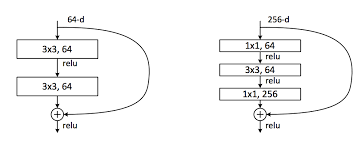
* Efficiency: Bottleneck blocks are more computationally efficient, especially in very deep networks.
* Complexity: Bottleneck blocks introduce more operations but reduce redundant computations through channel compression.

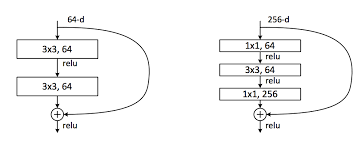

In [4]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * 4)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5749):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * 4),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


####  illustrate to show how _make_layer (downsample ) works:
 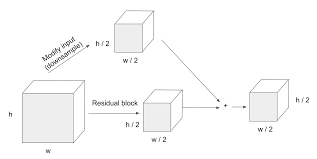
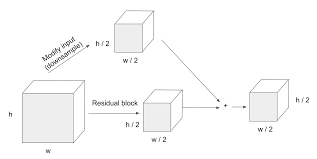

In [6]:
layers = [9, 9, 9, 9]  # 56 layers total
model = ResNet(BottleneckBlock, layers, num_classes=len(train_dataset.classes))


In [7]:

batch_size = 64
epochs = 20
lr = 0.001
weight_decay = 1e-4
step_size = 10
gamma = 0.1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss and predictions
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels, train_preds)
    train_losses.append(train_loss / len(train_loader))  

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss / len(val_loader))  

    # Step the scheduler
    scheduler.step()

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")


Epoch [1/20], Train Loss: 4.4442, Train Accuracy: 2.79%, Val Loss: 4.2631, Val Accuracy: 3.90%
Epoch [2/20], Train Loss: 4.0573, Train Accuracy: 5.56%, Val Loss: 3.9562, Val Accuracy: 6.54%
Epoch [3/20], Train Loss: 3.8081, Train Accuracy: 8.60%, Val Loss: 7.2016, Val Accuracy: 5.60%
Epoch [4/20], Train Loss: 3.7280, Train Accuracy: 10.38%, Val Loss: 3.7166, Val Accuracy: 10.12%
Epoch [5/20], Train Loss: 3.6307, Train Accuracy: 12.50%, Val Loss: 3.5923, Val Accuracy: 13.11%
Epoch [6/20], Train Loss: 3.4749, Train Accuracy: 15.20%, Val Loss: 3.1661, Val Accuracy: 21.74%
Epoch [7/20], Train Loss: 3.2597, Train Accuracy: 19.58%, Val Loss: 3.1777, Val Accuracy: 24.59%
Epoch [8/20], Train Loss: 3.0682, Train Accuracy: 23.35%, Val Loss: 2.7819, Val Accuracy: 29.46%
Epoch [9/20], Train Loss: 2.9019, Train Accuracy: 26.85%, Val Loss: 2.9696, Val Accuracy: 27.06%
Epoch [10/20], Train Loss: 2.7291, Train Accuracy: 30.54%, Val Loss: 2.6664, Val Accuracy: 31.83%
Epoch [11/20], Train Loss: 2.3648, 

In [8]:
def evaluate_model(model, data_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics calculation
    accuracy = accuracy_score(all_labels, all_preds)
    f_score = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return accuracy, f_score, precision, recall, conf_matrix, all_labels, all_probs

# Example usage
test_accuracy, f_score, precision, recall, conf_matrix, all_labels, all_probs = evaluate_model(
    model, test_dataset, num_classes=len(val_dataset.classes)
)


Accuracy: 60.98%
F1 Score: 0.6024
Precision: 0.6232
Recall: 0.6098


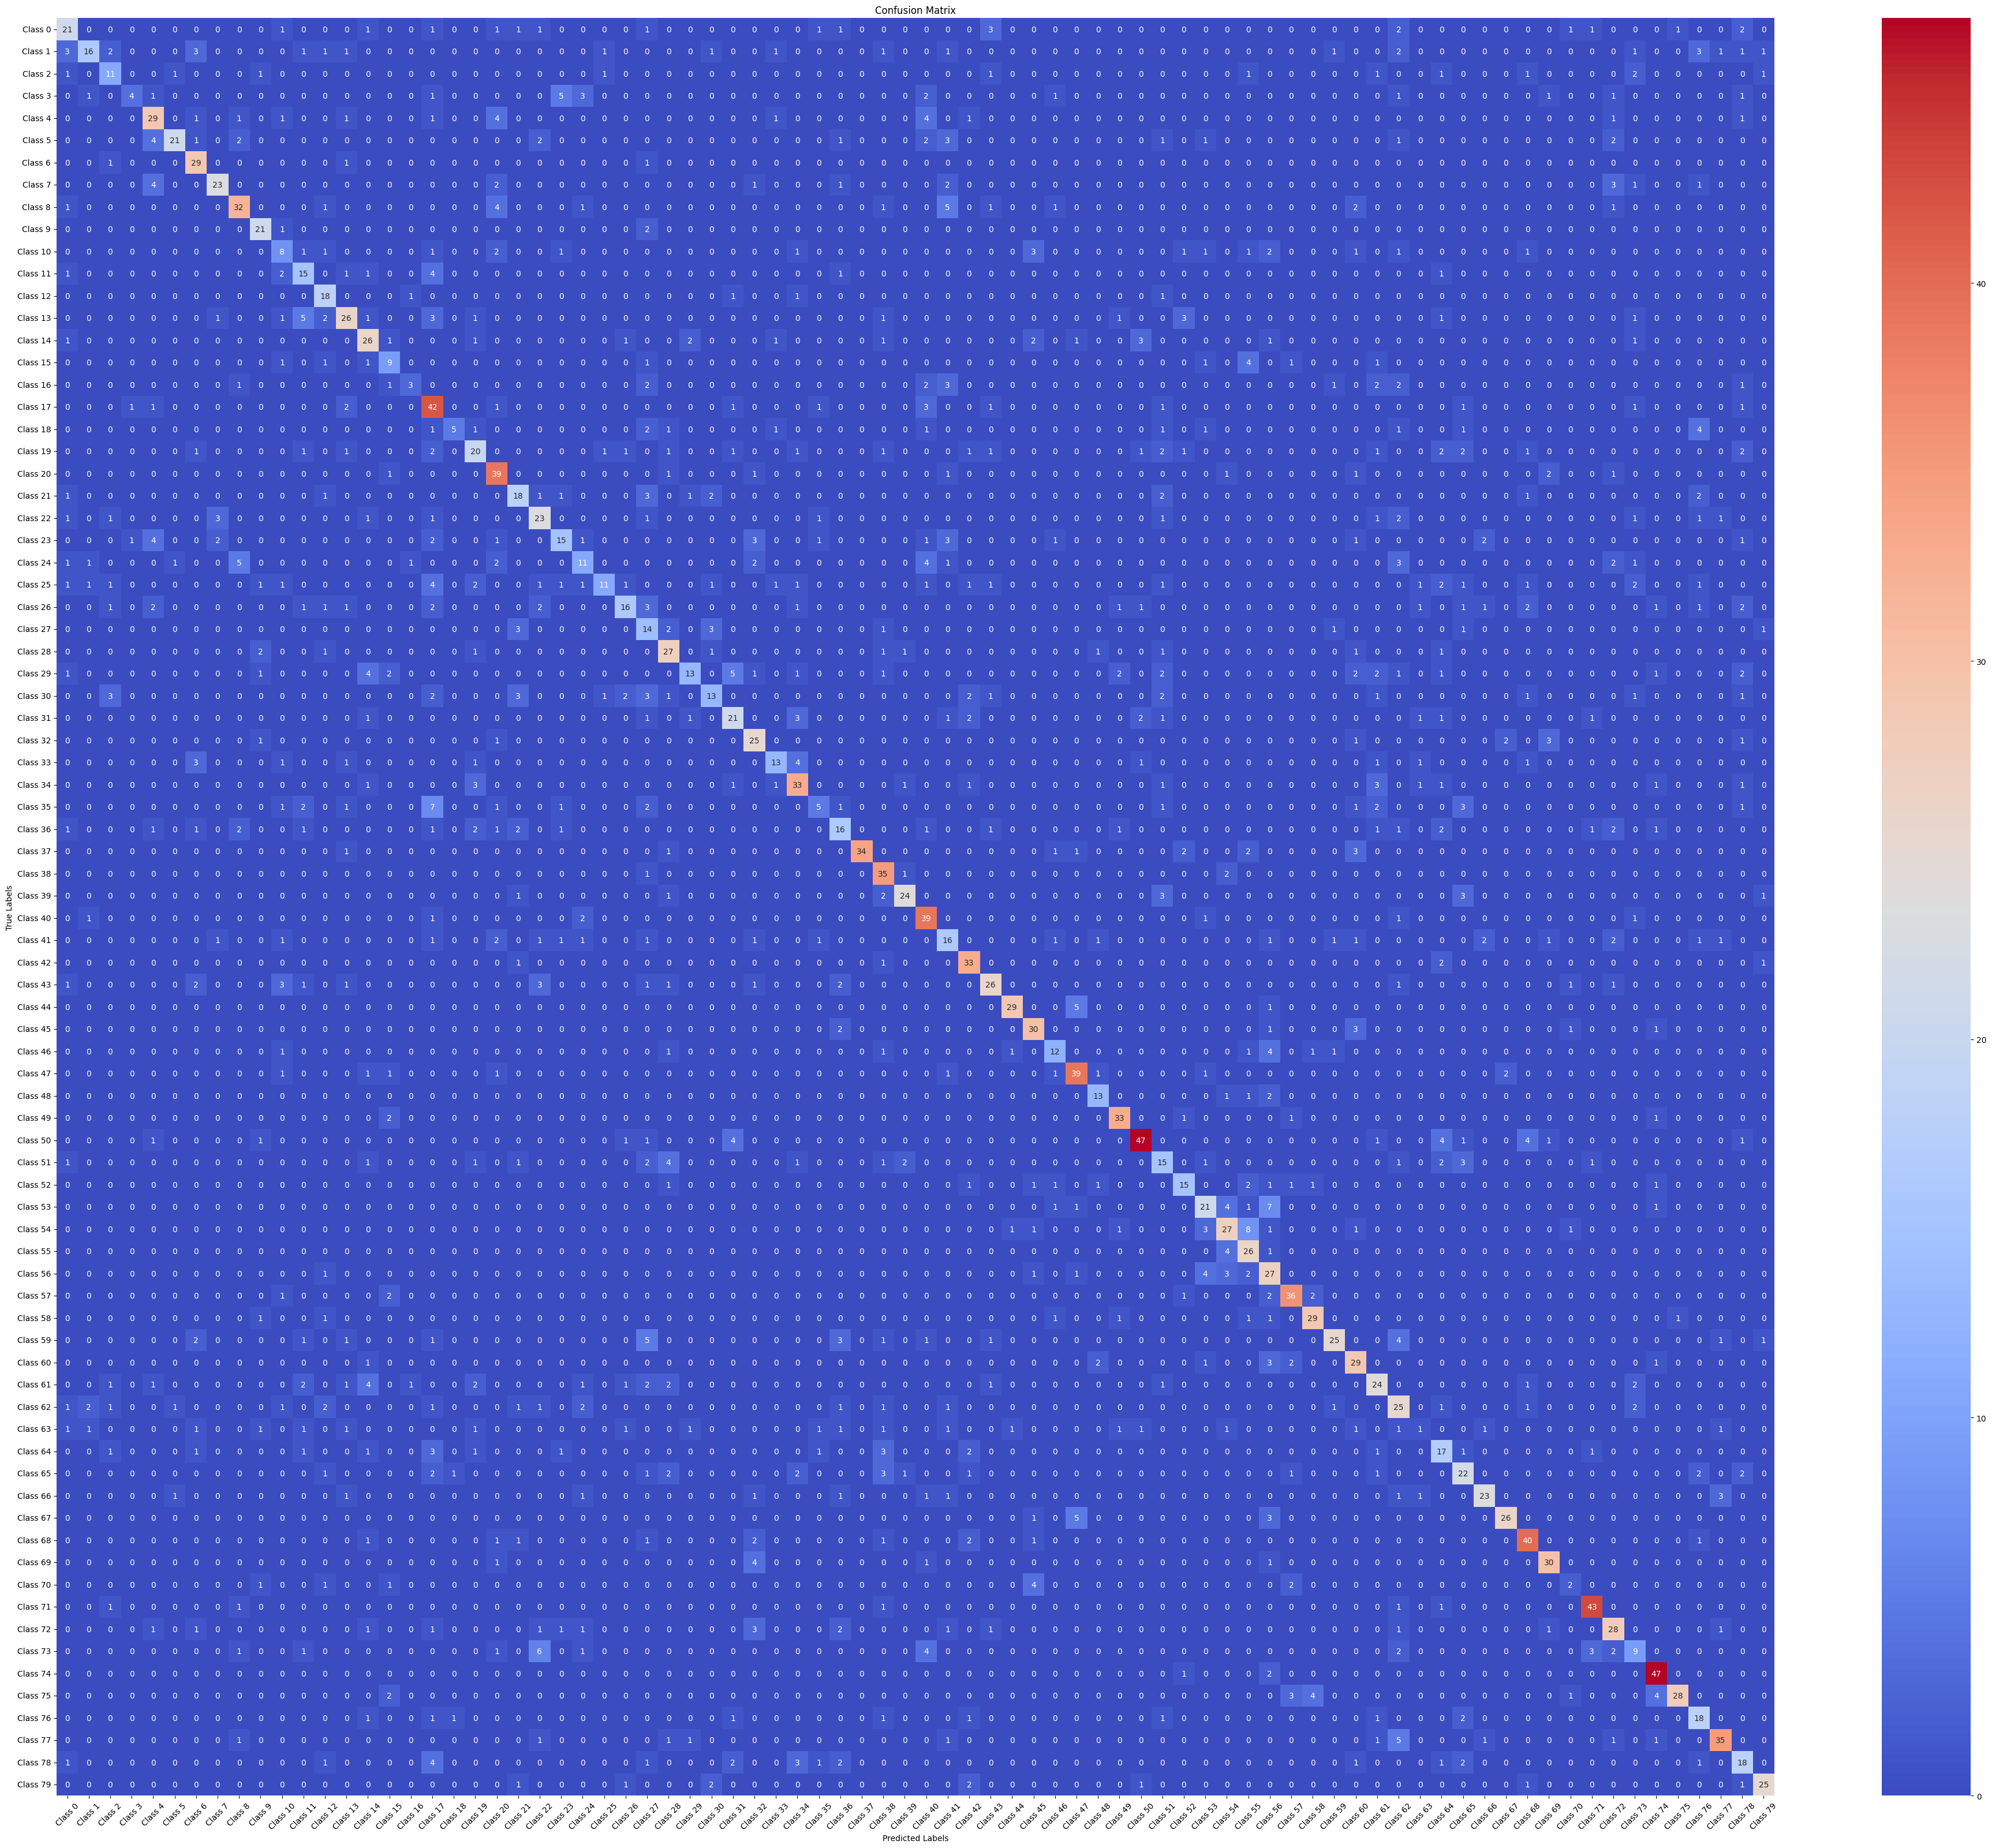

In [9]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(48, 40))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()


class_names = [f'Class {i}' for i in range(len(conf_matrix))]
plot_confusion_matrix(conf_matrix, class_names)


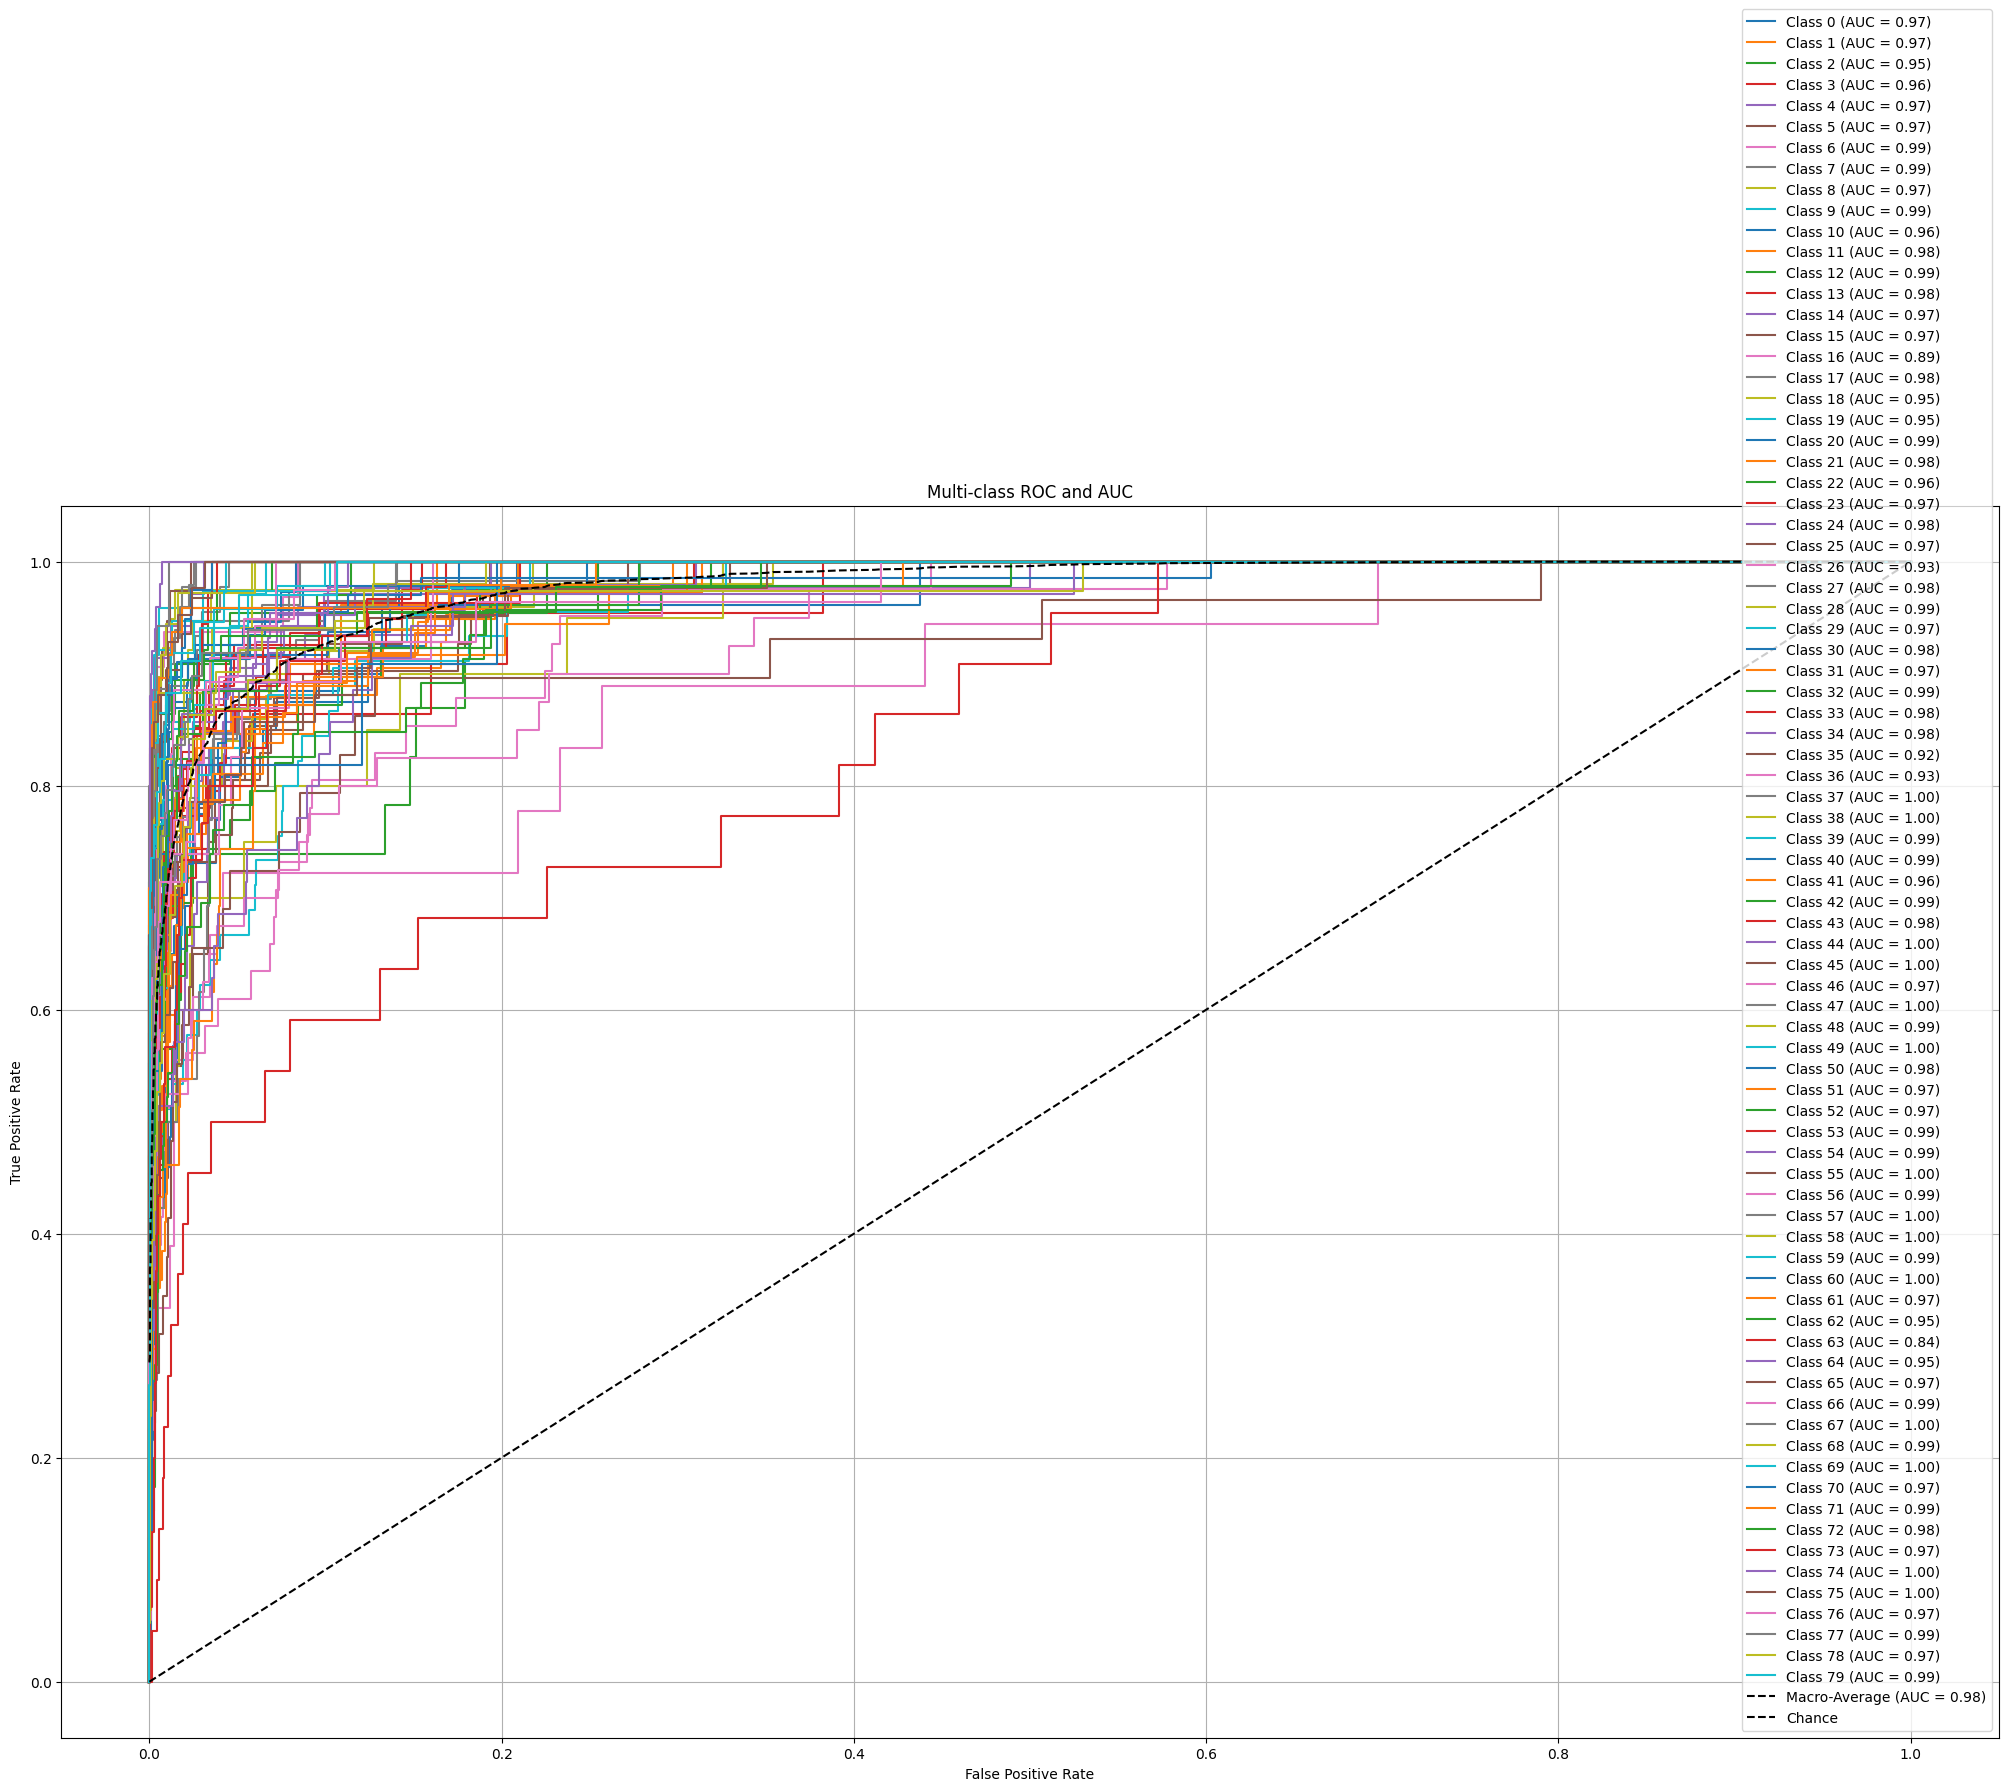

In [10]:
def plot_roc_auc(all_labels, all_probs, num_classes):
    # Binarize the labels for multi-class ROC
    y_true = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], [p[i] for p in all_probs])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

 # Plot all ROC curves
    plt.figure(figsize=(25, 16))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-Average (AUC = {roc_auc["macro"]:.2f})', linestyle='--', color='black')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC and AUC')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


plot_roc_auc(all_labels, all_probs, num_classes=len(val_dataset.classes))

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_auc_and_loss(all_labels, all_probs, losses, num_classes):
  
    # Binarize the labels for multi-class ROC
    y_true = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and ROC area for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], [p[i] for p in all_probs])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot both ROC curves and loss curve
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # ROC and AUC plot
    for i in range(num_classes):
        axs[0].plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    axs[0].plot(fpr["macro"], tpr["macro"], label=f'Macro-Average (AUC = {roc_auc["macro"]:.2f})', linestyle='--', color='black')
    axs[0].plot([0, 1], [0, 1], 'k--', label='Chance')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Multi-class ROC and AUC')
    axs[0].legend(loc="lower right")
    axs[0].grid()

    # Loss curve plot
    axs[1].plot(losses, label='Loss Curve', color='blue')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training/Validation Loss Curve')
    axs[1].legend(loc="upper right")
    axs[1].grid()

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_23/663860583.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


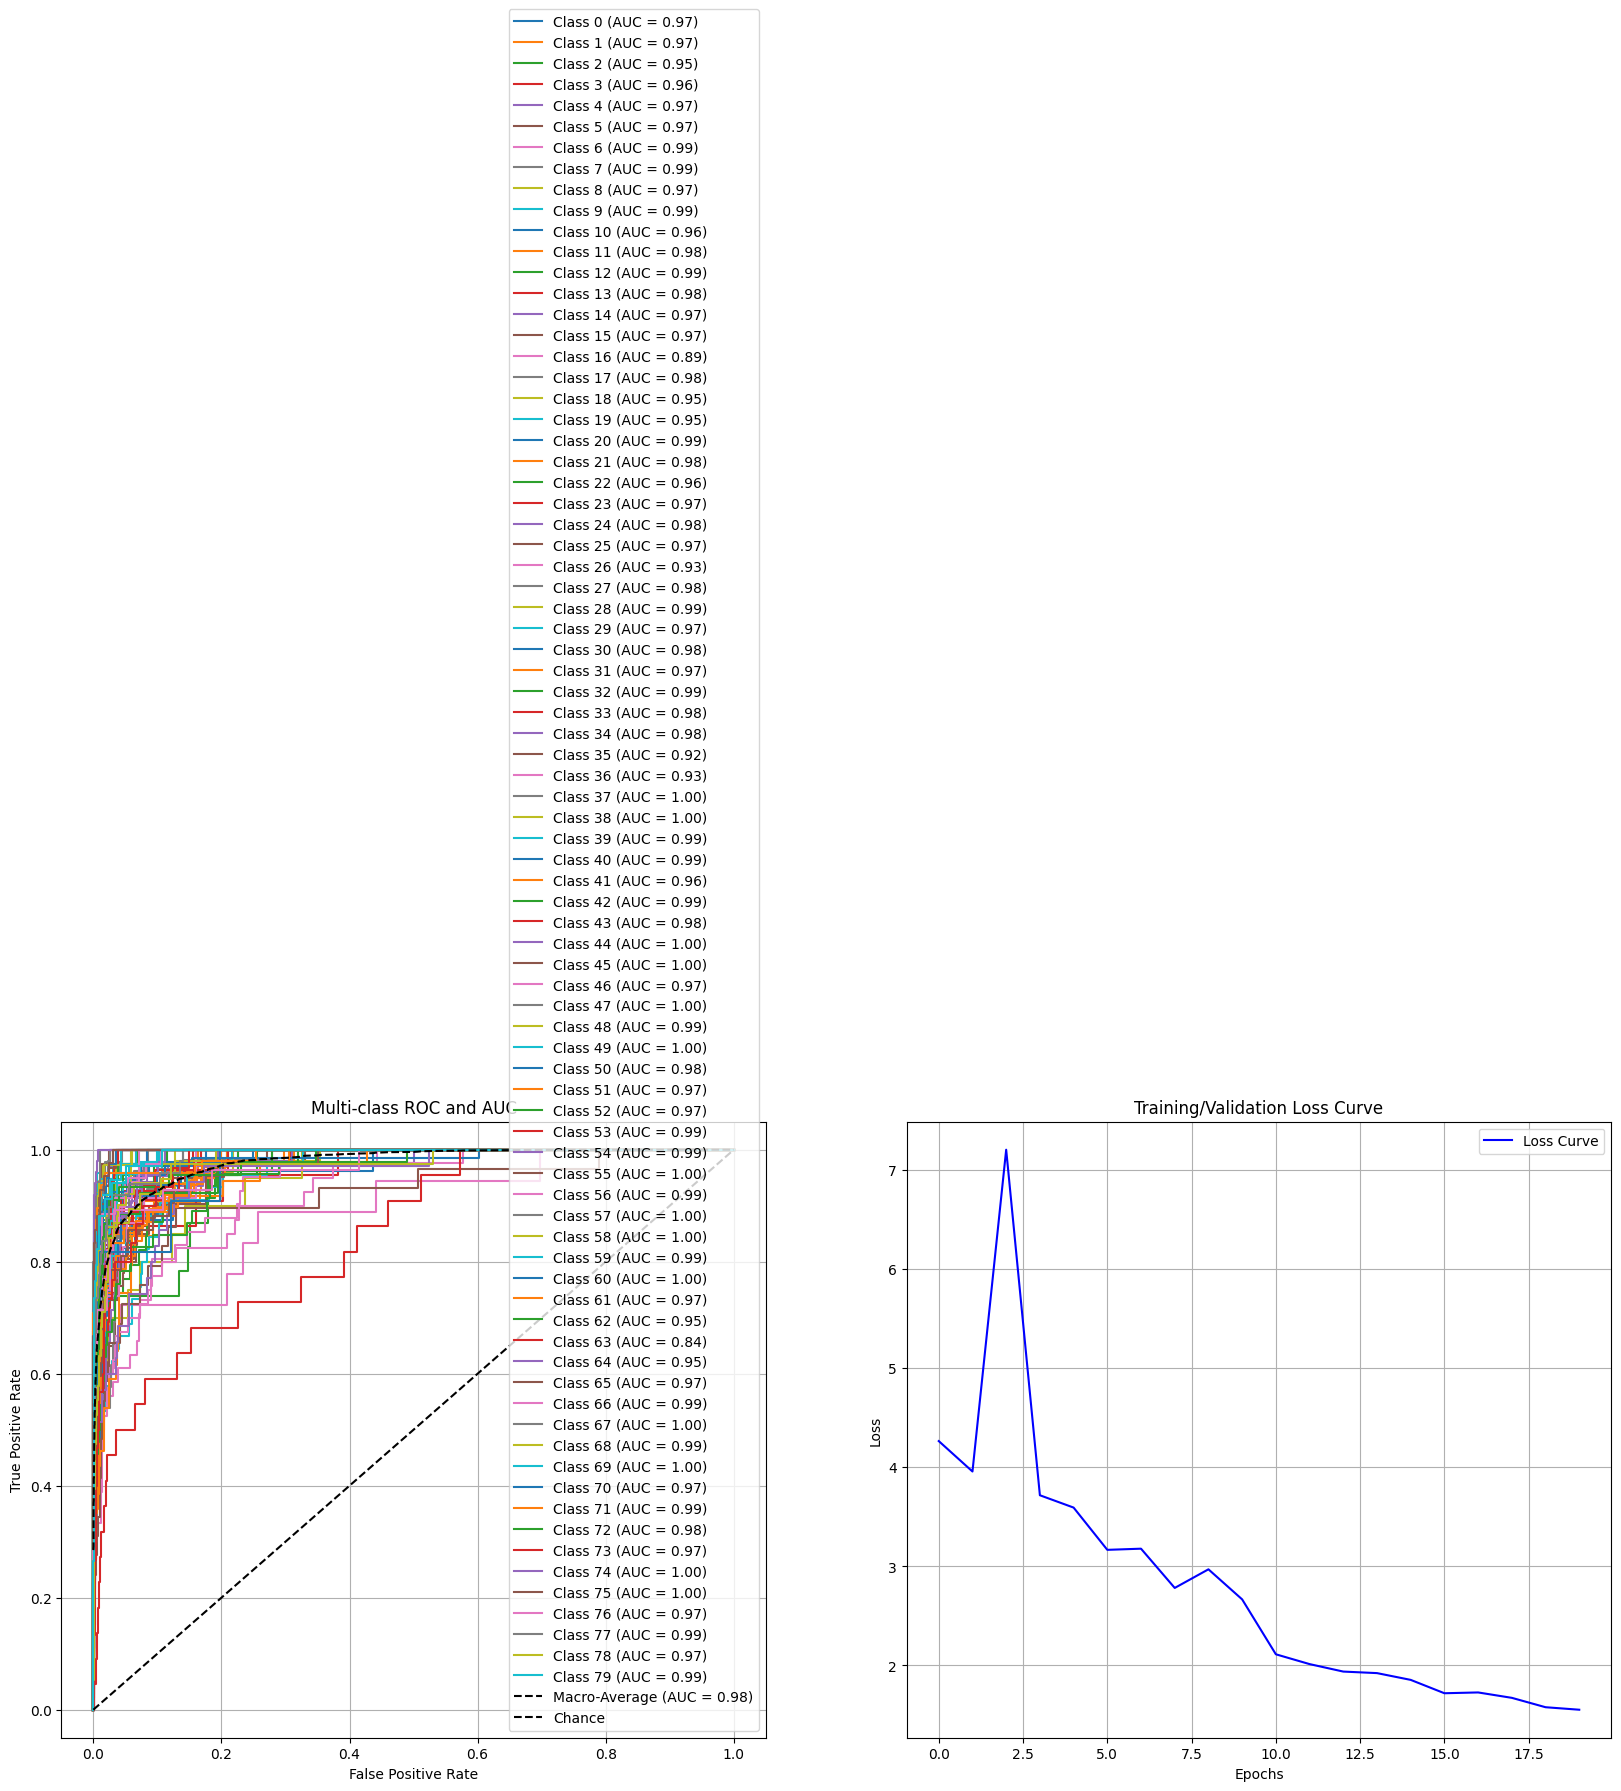

In [12]:
plot_roc_auc_and_loss(all_labels, all_probs, val_losses, num_classes =len(val_dataset.classes))

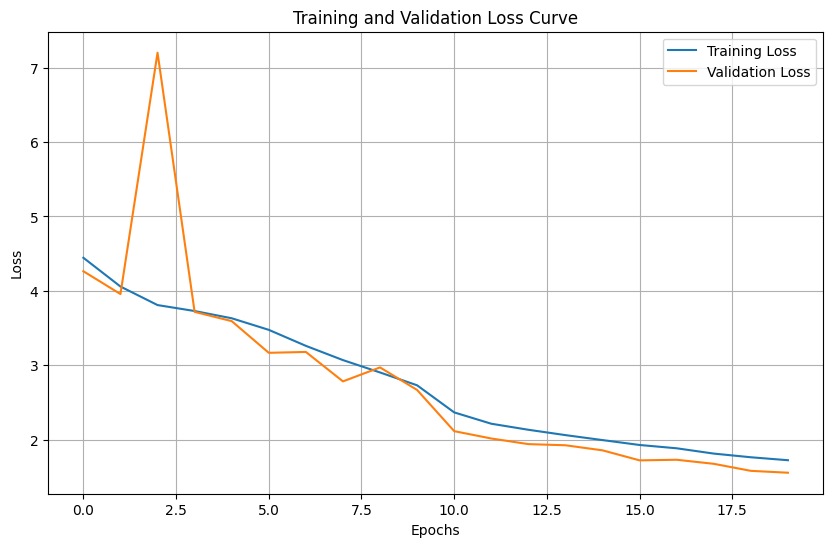

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()
